# **Image-to-Text (Image Captioning)**

- Transfomers
- Hugging face
- Pytorch


# set-up environment

In [ ]:
# install Hugging face transformers library and dataset
! pip install transformers datasets evaluate accelerate

# install package to evaluate an automatic speech recognition system
! pip install jiwer

In [ ]:
# import transformers package
import transformers

# Advanced Example

**Fine-tuning** a pre-trained BLIP model for your own tasks (Transfer Learning)




- **load the image captioning dataset**

In [ ]:
from datasets import load_dataset

dataset = load_dataset("keremberke/chest-xray-classification", 'mini')
dataset

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 4
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 4
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 4
    })
})

In [ ]:
# Split the dataset’s train split into a train and test set
# with the [~datasets.Dataset.train_test_split] :

dataset = dataset["train"].train_test_split(test_size=0.1)
train_ds = dataset["train"]
test_ds = dataset["test"]

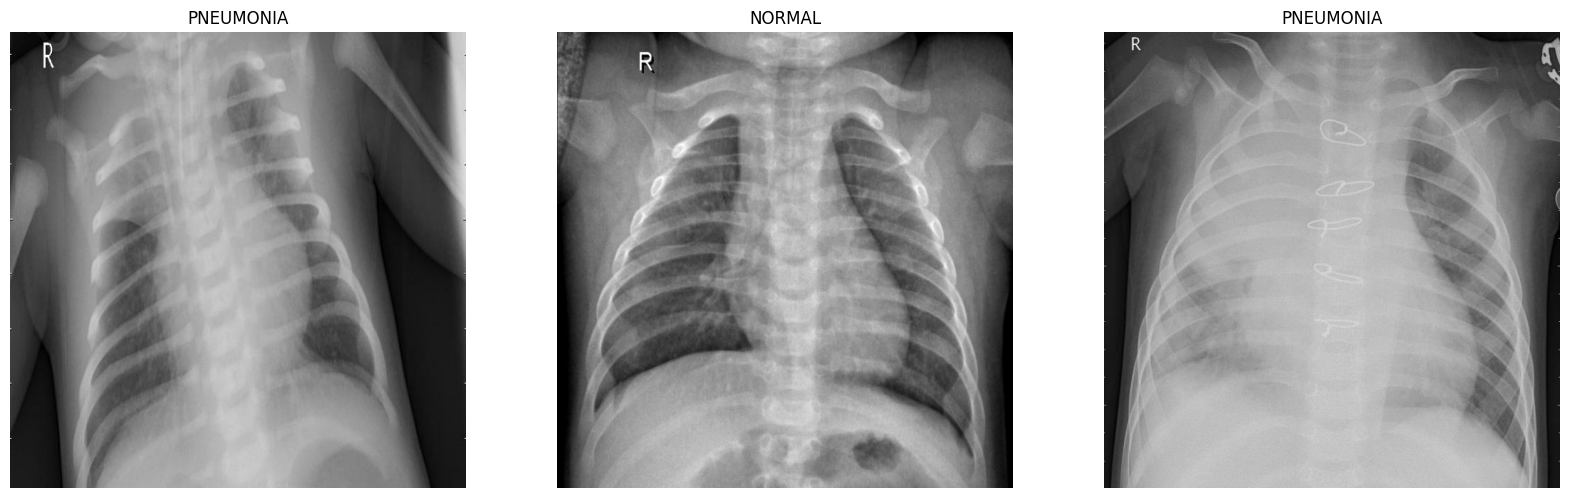

In [ ]:
# Visualize a couple of samples from the training set

from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")


sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in range(3)]
sample_captions = ["NORMAL" if train_ds[i]["labels"] == 0 else "PNEUMONIA" for i in range(3)]
plot_images(sample_images_to_visualize, sample_captions)

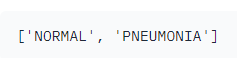

- **Preprocess the dataset**
 * the dataset has two modalities (image and text)
 * the pre-processing pipeline will preprocess images and the captions.

In [ ]:
# load the processor class associated with the model you are about to fine-tune
from transformers import AutoProcessor

checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)

In [ ]:
# Internally pre-process the image (which includes resizing, and pixel scaling) and tokenize the caption.
def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = ["NORMAL" if x == 0 else "PNEUMONIA" for x in example_batch["labels"]]
    #captions = [str(x) for x in example_batch["labels"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs


train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

- **Load a base model**

In [ ]:
from transformers import AutoModelForCausalLM

# Load the checkpoint('microsoft/git-base') into a AutoModelForCausalLM object
model = AutoModelForCausalLM.from_pretrained(checkpoint)

- **Evaluate**

In [ ]:
from evaluate import load
import torch

# Image captioning models are typically evaluated with the Rouge Score or Word Error Rate
# In this example, we will use the Word Error Rate (WER)
wer = load("wer")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

- **Train the model**

In [ ]:
#define the training arguments using TrainingArguments
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = "./pneumonia", #저장 위치, ./ 형태로 설정하면 미리 만들 필요 X
    learning_rate=5e-5,
    num_train_epochs=200,
    fp16=True, #True when using GPU
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2, #gradient 계산 시(backpropagation) 누적되는 step의 개수
    save_total_limit=3, #저장되는 checkpoint의 최대 개수
    evaluation_strategy="steps", #step 단위로 평가
    eval_steps=10, #evaluation_loss 출력 단위
    save_strategy="steps",
    save_steps=10,
    logging_steps=10, #train_loss 출력 단위
    remove_unused_columns=False,
    push_to_hub=True,
    label_names=["labels"],
    load_best_model_at_end=True,
)

In [ ]:
# Login to your Hugging Face account to get token
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
# Pass the training arguments along with the datasets and the model to Hugging face Trainer.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics
)

/content/BLIP-simpsons is already a clone of https://huggingface.co/AIove/BLIP-simpsons. Make sure you pull the latest changes with `repo.git_pull()`.


In [ ]:
# start training
trainer.train()

Step,Training Loss,Validation Loss,Wer Score
10,1.890100,3.088609,1.000000
20,1.378900,2.151631,1.000000
30,0.946100,1.401159,1.000000
40,0.612200,0.866583,1.000000
50,0.382600,0.530734,1.000000
60,0.240900,0.335699,1.000000
70,0.159900,0.228877,0.000000
80,0.115400,0.172830,0.000000
90,0.092000,0.145502,0.000000
100,0.081600,0.136745,0.000000


TrainOutput(global_step=100, training_loss=0.5899645328521729, metrics={'train_runtime': 374.9352, 'train_samples_per_second': 0.8, 'train_steps_per_second': 0.267, 'total_flos': 140304791347200.0, 'train_loss': 0.5899645328521729, 'epoch': 100.0})

- **Inference**

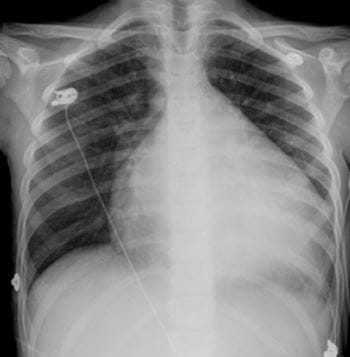

In [ ]:
# Take a sample image
from PIL import Image
import requests

url = "https://www.msdmanuals.com/-/media/manual/home/images/5/2/3/523-dilated-cardiomyopathy-chest-x-ray-s116-springer-high_ko.jpg?mw=350&amp;thn=0&amp;sc_lang=ko"
image = Image.open(requests.get(url, stream=True).raw)
image

In [ ]:
# Prepare image for the model.
device = "cuda" if torch.cuda.is_available() else "cpu"

inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

In [ ]:
# Call generate and decode the predictions.
generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)
print("end")

normal
end


PNEMONIA도 뜨는지?-비율에 따라 정확도가 높아도 잘 나오지 않을 확률이 있으니 확인 필요

일반 CLASSIFICATION과의 강점? 표현의 다양성(OUTPUT 출력 시 확률에 따라 분류)?